# Section3a - Dataset preparation
We will start by deciding which features we want to use in the machine learning prediction of the severity of the accident for each user.
We'll also do a final clean up of the features to remove bad entries.
The new dataframe with the target and wanted features will be entirely stored in a MySQL database to be used later on in the rest of the Section3.

The creation of the training and testing samples from the dataset stored in the MySQL database will be detailed at the end of this section. This last process creating these samples will be implemented in the file CreateTrainAndTestSamples.py to be called in the following part of Section3.

## Dataset details
**The target** data is the severity column in the Users dataframe.

**The features** useful in the machine learning to predict the severity of the accident are:
- *From Users dataframe*
 - Location in vehicle
 - User type
 - Sexe
 - Age
 - Journey type
 - Safety gear type
 - Safety gear worn
 - Pedestrian location (Too many entries set to "not recorded" => not used)
 - Pedestrian action (Too many entries set to "not recorded" => not used)
- *From characteristics dataframe*
 - Luminosity
 - In city
 - Intersect type
 - Weather
 - Collision type
- *From Locations dataframe*
 - Road type
 - Traffic mode
 - Nb Lanes
 - Road profil
 - Road surface
 - Road width (Too many entries set to "not recorded" => not used)
 - Installations (Too many entries set to "not recorded" => not used)
 - Location
- *From Vehicles dataframe*
 - Vehicle type
 - Fixed object hit
 - Moving obj hit
 - Impact location
 - Maneuver
- *Engineered variables*
 - Max weight differential (Between the vehicle of the user and the heaviest vehicle in the accident, or the weight of the pedestrian and the weight of the vehicle that hit them)


In [1]:
import pandas as pd
import numpy as np
# Provides better color palettes
import seaborn as sns

from pandas import DataFrame,Series

import matplotlib as mpl
import matplotlib.pyplot as plt
# Command to display the plots in the iPython Notebook
%matplotlib inline
import matplotlib.patches as mpatches

mpl.style.use('seaborn-whitegrid')
plt.style.use('seaborn-talk')
# Extract the list of colors from this style for later use
cycl = mpl.rcParams['axes.prop_cycle']
colors = cycl.by_key()['color']

In [2]:
from CSVtoSQLconverter import load_sql_engine
sqlEngine = load_sql_engine()

## Target and Features from the Users dataframe
We start with the Users dataframe because each entry in our features dataframe will correspond to one road user involved in an accident and have the target.

In [3]:
users_df = pd.read_sql_query('SELECT * FROM safer_roads.users',
                            sqlEngine)
users_df.head()

,accident id,pedestrian action,user type,pedestrian company,severity,pedestrian location,vehicle id,location in vehicle,safety gear type,safety gear worn,sex,journey type,age
0,201000000001,0.0,1,0.0,3,0.0,A01,1.0,2.0,1.0,1,5.0,34.0
1,201000000002,0.0,1,0.0,1,0.0,A01,1.0,1.0,1.0,2,5.0,27.0
2,201000000002,3.0,3,1.0,3,4.0,A01,NaN,NaN,NaN,1,0.0,45.0
3,201000000003,0.0,1,0.0,3,0.0,A01,1.0,2.0,3.0,1,5.0,31.0
4,201000000003,0.0,1,0.0,1,0.0,C03,1.0,1.0,1.0,2,5.0,51.0


We keep the original numbers of entries in this dataframe to know how much we lost overall during the preparation of the dataset.

In [4]:
original_nb_entries = users_df.shape[0]

In [5]:
pd.options.display.float_format = '{:20,.2f}'.format

def check_columns(dataf,columns):
    zeroes_sr = (dataf[columns] == 0).astype(int).sum(axis=0)
    neg_sr = (dataf[columns] < 0).astype(int).sum(axis=0)
    nans_sr = dataf[columns].isnull().sum()
    
    nbent = dataf.shape[0]
    rows = []
    rows.append(DataFrame(zeroes_sr,columns=['nb zeroes']))
    rows.append(DataFrame((100*zeroes_sr/nbent),columns=['% zeroes']))
    rows.append(DataFrame(neg_sr,columns=['nb neg. vals']))
    rows.append(DataFrame((100*neg_sr/nbent),columns=['% neg. vals']))
    rows.append(DataFrame(nans_sr,columns=['nb nans']))
    rows.append(DataFrame((100*nans_sr/nbent),columns=['% nans']))

    checks_df = pd.concat(rows,axis=1)
    print(' - Total number of entries: {}\n'.format(dataf.shape[0]))
    print('List of NaN, zero and negative entries:\n{}\n\n'.format(checks_df))

In [6]:
check_columns(users_df, ['location in vehicle', 'user type', 'age', 'sex',
                       'journey type', 'safety gear worn','safety gear type',
                       'pedestrian action', 'pedestrian location','severity'])

 - Total number of entries: 702243

List of NaN, zero and negative entries:
                     nb zeroes             % zeroes  nb neg. vals  \
location in vehicle          0                 0.00             0   
user type                    0                 0.00             0   
age                       1003                 0.14             0   
sex                          0                 0.00             0   
journey type            186307                26.53             0   
safety gear worn             0                 0.00             0   
safety gear type             0                 0.00             0   
pedestrian action       641143                91.30             0   
pedestrian location     644536                91.78             0   
severity                     0                 0.00             0   

                             % neg. vals  nb nans               % nans  
location in vehicle                 0.00    63010                 8.97  
user type         

A few different corrections are needed:
1. For "location in vehicle" we can replace the NaN with zeros as a consistent place holder to specify that this wasn't recorded.
1. The entries with NaN values in the "age" column can be safely removed since they represent very few entries. The zeroes in that column should be babies less than one year old.
1. The "journey type", "safety gear worn", and "safety gear type" have a category "unknown" or "other" which we can use to replace the NaN entries. We can also use this category for the entries with zero in journey type.
1. The "pedestrian action" and "pedestrian location" are mostly filled with zeroes indicating that they were not recorded therefore we won't use them as features.

In [7]:
# 1. Replace NaN with zeros
users_df['location in vehicle'].fillna(0, inplace=True)
# 2. Remove rows with NaN in age column
users_df.dropna(subset=['age'], inplace=True)
# 3. Replace NaN with "other" or "unknown" categories
users_df['journey type'].fillna(9, inplace=True)
users_df['safety gear type'].fillna(9, inplace=True)
users_df['safety gear worn'].fillna(3, inplace=True)
users_df.replace(to_replace={'journey type':{0:9}}, inplace=True)

In [8]:
check_columns(users_df, ['location in vehicle', 'user type', 'age', 'sex',
                       'journey type', 'safety gear worn','safety gear type',
                       'severity'])

 - Total number of entries: 702053

List of NaN, zero and negative entries:
                     nb zeroes             % zeroes  nb neg. vals  \
location in vehicle      63001                 8.97             0   
user type                    0                 0.00             0   
age                       1003                 0.14             0   
sex                          0                 0.00             0   
journey type                 0                 0.00             0   
safety gear worn             0                 0.00             0   
safety gear type             0                 0.00             0   
severity                     0                 0.00             0   

                             % neg. vals  nb nans               % nans  
location in vehicle                 0.00        0                 0.00  
user type                           0.00        0                 0.00  
age                                 0.00        0                 0.00  
sex       

In [9]:
feat_target_df = users_df[['accident id','vehicle id','severity','location in vehicle', 'user type',
                        'age', 'sex', 'journey type', 'safety gear worn','safety gear type']]
feat_target_df.head()

,accident id,vehicle id,severity,location in vehicle,user type,age,sex,journey type,safety gear worn,safety gear type
0,201000000001,A01,3,1.00,1,34.00,1,5.00,1.00,2.00
1,201000000002,A01,1,1.00,1,27.00,2,5.00,1.00,1.00
2,201000000002,A01,3,0.00,3,45.00,1,9.00,3.00,9.00
3,201000000003,A01,3,1.00,1,31.00,1,5.00,3.00,2.00
4,201000000003,C03,1,1.00,1,51.00,2,5.00,1.00,1.00


## Features from the Characteristics dataframe

In [10]:
charact_df = pd.read_sql_query('SELECT * FROM safer_roads.characteristics',
                            sqlEngine)
charact_df.head()

,accident id,luminosity,in city,intersect type,weather,collision type,city id,area id,datetime
0,201000000001,1,2,1,1.00,6.00,52,59,2010-06-12 19:30:00
1,201000000002,1,2,1,1.00,6.00,477,59,2010-08-07 10:00:00
2,201000000003,1,1,1,1.00,5.00,11,59,2010-09-11 16:00:00
3,201000000004,1,2,1,1.00,6.00,477,59,2010-09-22 16:30:00
4,201000000005,1,2,1,1.00,2.00,52,59,2010-10-25 12:15:00


In [11]:
wanted_cols = ['luminosity', 'in city', 'intersect type', 'weather', 'collision type']
check_columns(charact_df, wanted_cols)

 - Total number of entries: 316854

List of NaN, zero and negative entries:
                nb zeroes             % zeroes  nb neg. vals  \
luminosity              0                 0.00             0   
in city                 0                 0.00             0   
intersect type         88                 0.03             0   
weather                 0                 0.00             0   
collision type          0                 0.00             0   

                        % neg. vals  nb nans               % nans  
luminosity                     0.00        0                 0.00  
in city                        0.00        0                 0.00  
intersect type                 0.00        0                 0.00  
weather                        0.00       48                 0.02  
collision type                 0.00        9                 0.00  




The intersection type has values 0 which do not correspond to anything but they concern very few instances overall. We can drop them.

On the other hand some weather and collision type entries contain NaN. The categories 9 and 6 are for "other" respectively in weather and collision type. Since very few entries have NaN, we can put the NaN in this vague category.

In [12]:
charact_df['weather'].fillna(9,inplace=True)
charact_df['collision type'].fillna(6,inplace=True)
charact_df = charact_df[charact_df['intersect type'] != 0]

In [13]:
check_columns(charact_df, wanted_cols)

 - Total number of entries: 316766

List of NaN, zero and negative entries:
                nb zeroes             % zeroes  nb neg. vals  \
luminosity              0                 0.00             0   
in city                 0                 0.00             0   
intersect type          0                 0.00             0   
weather                 0                 0.00             0   
collision type          0                 0.00             0   

                        % neg. vals  nb nans               % nans  
luminosity                     0.00        0                 0.00  
in city                        0.00        0                 0.00  
intersect type                 0.00        0                 0.00  
weather                        0.00        0                 0.00  
collision type                 0.00        0                 0.00  




In [14]:
wanted_cols.append('accident id')
feat_target_df = feat_target_df.merge(charact_df[wanted_cols],
                             on=['accident id'],how='inner')
print(' -> Number of entries in the dataset: {}\n'.format(feat_target_df.shape[0]))
feat_target_df.head()

 -> Number of entries in the dataset: 701848



,accident id,vehicle id,severity,location in vehicle,user type,age,sex,journey type,safety gear worn,safety gear type,luminosity,in city,intersect type,weather,collision type
0,201000000001,A01,3,1.00,1,34.00,1,5.00,1.00,2.00,1,2,1,1.00,6.00
1,201000000002,A01,1,1.00,1,27.00,2,5.00,1.00,1.00,1,2,1,1.00,6.00
2,201000000002,A01,3,0.00,3,45.00,1,9.00,3.00,9.00,1,2,1,1.00,6.00
3,201000000003,A01,3,1.00,1,31.00,1,5.00,3.00,2.00,1,1,1,1.00,5.00
4,201000000003,C03,1,1.00,1,51.00,2,5.00,1.00,1.00,1,1,1,1.00,5.00


## Features from the Vehicles dataframe

In [15]:
vehicles_df = pd.read_sql_query('SELECT * FROM safer_roads.vehicles',
                            sqlEngine)
vehicles_df.head()

,accident id,vehicle type,nb occupants public transit,fixed obj hit,moving obj hit,impact location,maneuver,vehicle id
0,201000000001,13,0,1.00,0.00,1.00,1.00,A01
1,201000000002,4,0,0.00,1.00,1.00,1.00,A01
2,201000000003,16,0,0.00,2.00,1.00,17.00,A01
3,201000000003,4,0,0.00,9.00,3.00,23.00,C03
4,201000000003,4,0,0.00,9.00,6.00,1.00,B02


In [16]:
wanted_cols = ['vehicle type', 'fixed obj hit', 'moving obj hit',
              'impact location', 'maneuver']
check_columns(vehicles_df, wanted_cols)

 - Total number of entries: 538098

List of NaN, zero and negative entries:
                 nb zeroes             % zeroes  nb neg. vals  \
vehicle type             0                 0.00             0   
fixed obj hit       469692                87.29             0   
moving obj hit      113809                21.15             0   
impact location      34944                 6.49             0   
maneuver             41858                 7.78             0   

                         % neg. vals  nb nans               % nans  
vehicle type                    0.00        0                 0.00  
fixed obj hit                   0.00      397                 0.07  
moving obj hit                  0.00      353                 0.07  
impact location                 0.00      149                 0.03  
maneuver                        0.00      188                 0.03  




Vehicle type is perfectly fine. The other 4 columns have a very small number of entries with NaNs and a large number of zeros representing the missing information or in the case of the obj hit the fact that no obj, fixed or moving, was hit. SO we can replace the NaNs with zeros.

In [17]:
for col in wanted_cols[1:]:
    vehicles_df[col].fillna(0,inplace=True)

In [18]:
wanted_cols.extend(['accident id','vehicle id'])
feat_target_df = feat_target_df.merge(vehicles_df[wanted_cols],
                                on=['accident id','vehicle id'],how='inner')
feat_target_df.head()

,accident id,vehicle id,severity,location in vehicle,user type,age,sex,journey type,safety gear worn,safety gear type,luminosity,in city,intersect type,weather,collision type,vehicle type,fixed obj hit,moving obj hit,impact location,maneuver
0,201000000001,A01,3,1.00,1,34.00,1,5.00,1.00,2.00,1,2,1,1.00,6.00,13,1.00,0.00,1.00,1.00
1,201000000002,A01,1,1.00,1,27.00,2,5.00,1.00,1.00,1,2,1,1.00,6.00,4,0.00,1.00,1.00,1.00
2,201000000002,A01,3,0.00,3,45.00,1,9.00,3.00,9.00,1,2,1,1.00,6.00,4,0.00,1.00,1.00,1.00
3,201000000003,A01,3,1.00,1,31.00,1,5.00,3.00,2.00,1,1,1,1.00,5.00,16,0.00,2.00,1.00,17.00
4,201000000003,C03,1,1.00,1,51.00,2,5.00,1.00,1.00,1,1,1,1.00,5.00,4,0.00,9.00,3.00,23.00


## Features from the Locations dataframe

In [19]:
locations_df = pd.read_sql_query('SELECT * FROM safer_roads.locations',
                            sqlEngine)
locations_df.head()

,accident id,road type,traffic mode,nb lanes,reserved lane,road profil,road alignment,central reservation,road width,road surface,installations,location,school distance
0,201000000001,3,2.00,2.00,0.00,1.00,1.00,0.00,60.00,1.00,0.00,1.00,0.00
1,201000000002,3,2.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00
2,201000000003,3,2.00,2.00,0.00,1.00,1.00,0.00,61.00,1.00,0.00,1.00,0.00
3,201000000004,3,2.00,2.00,0.00,1.00,1.00,0.00,68.00,1.00,0.00,1.00,0.00
4,201000000005,3,2.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,99.00


In [20]:
wanted_cols = ['road type', 'traffic mode', 'nb lanes',
              'road profil', 'road alignment','road surface',
               'road width', 'installations', 'location']
check_columns(locations_df, wanted_cols)

 - Total number of entries: 316854

List of NaN, zero and negative entries:
                nb zeroes             % zeroes  nb neg. vals  \
road type               0                 0.00             0   
traffic mode        17678                 5.58             0   
nb lanes            37541                11.85             0   
road profil         23340                 7.37             0   
road alignment      22355                 7.06             0   
road surface         9943                 3.14             0   
road width         111729                35.26             0   
installations      281992                89.00             0   
location            15218                 4.80             0   

                        % neg. vals  nb nans               % nans  
road type                      0.00        0                 0.00  
traffic mode                   0.00      523                 0.17  
nb lanes                       0.00      794                 0.25  
road profil

For most columns we can again simply replace NaN by 0 which corresponds to an "unknown" category.

The columns "road width" and "installations" have respectively 35% and 90% of zeros so it is preferable to drop them.

In [21]:
wanted_cols.remove('road width')
wanted_cols.remove('installations')

In [22]:
for col in wanted_cols[1:]:
    locations_df[col].fillna(0,inplace=True)

In [23]:
wanted_cols.extend(['accident id'])
feat_target_df = feat_target_df.merge(locations_df[wanted_cols],
                                on=['accident id'],how='inner')
feat_target_df.head()

,accident id,vehicle id,severity,location in vehicle,user type,age,sex,journey type,safety gear worn,safety gear type,...,moving obj hit,impact location,maneuver,road type,traffic mode,nb lanes,road profil,road alignment,road surface,location
0,201000000001,A01,3,1.00,1,34.00,1,5.00,1.00,2.00,...,0.00,1.00,1.00,3,2.00,2.00,1.00,1.00,1.00,1.00
1,201000000002,A01,1,1.00,1,27.00,2,5.00,1.00,1.00,...,1.00,1.00,1.00,3,2.00,0.00,1.00,1.00,1.00,1.00
2,201000000002,A01,3,0.00,3,45.00,1,9.00,3.00,9.00,...,1.00,1.00,1.00,3,2.00,0.00,1.00,1.00,1.00,1.00
3,201000000003,A01,3,1.00,1,31.00,1,5.00,3.00,2.00,...,2.00,1.00,17.00,3,2.00,2.00,1.00,1.00,1.00,1.00
4,201000000003,C03,1,1.00,1,51.00,2,5.00,1.00,1.00,...,9.00,3.00,23.00,3,2.00,2.00,1.00,1.00,1.00,1.00


## Engineered features
From the existing features we can derive new features to improve the predicting power.

### Weight differential
The relative size of the vehicles involved in an accident has a direct impact on the gravity of the accident. A complementary piece of information would be the speed to deduce the momentum however we do not have any data on that.

When going through the dataset user by user, the vehicle information associated to each driver or passenger ('user type' = 1 or 2) correspond to their own vehicle therefore we have no information on the other vehicles in the accident. If the entry is for a pedestrian ('user type' = 3 or 4) then the associated vehicle is the vehicle that hit the pedestrian.

We will create a new column for the weight differential taking into account the two cases:
- for passengers and drivers the difference will be between their vehicle and the heaviest vehicle involved in the accident
- for pedestrian will simply take the weight of the vehicle that hit them

The mapping from 'vehicle type' to a crude estimate of the average vehicle weight in kilograms is stored in the [Mapper.py](https://github.com/hillairet/analysis-for-safer-roads/blob/master/Mapper.py) script.

In [24]:
from Mapper import Vehicle_Weights
# Frist we map all the vehicle types to the average weight
feat_target_df['weight diff'] = feat_target_df['vehicle type'].map(Vehicle_Weights)
# Then calculate the differential for drivers and passengers
mask = feat_target_df['user type'].isin([1,2])
feat_target_df.ix[mask,'weight diff'] = feat_target_df.groupby('accident id')['weight diff']\
                                        .transform(lambda x: x - x.max())

## Randomize entries
In order to facilitate the creation of test and training samples in the next section, we shuffle now the entries in the dataframe prior to storing them in the SQL database.

In [25]:
feat_target_df.head()

,accident id,vehicle id,severity,location in vehicle,user type,age,sex,journey type,safety gear worn,safety gear type,...,impact location,maneuver,road type,traffic mode,nb lanes,road profil,road alignment,road surface,location,weight diff
0,201000000001,A01,3,1.00,1,34.00,1,5.00,1.00,2.00,...,1.00,1.00,3,2.00,2.00,1.00,1.00,1.00,1.00,0
1,201000000002,A01,1,1.00,1,27.00,2,5.00,1.00,1.00,...,1.00,1.00,3,2.00,0.00,1.00,1.00,1.00,1.00,0
2,201000000002,A01,3,0.00,3,45.00,1,9.00,3.00,9.00,...,1.00,1.00,3,2.00,0.00,1.00,1.00,1.00,1.00,1200
3,201000000003,A01,3,1.00,1,31.00,1,5.00,3.00,2.00,...,1.00,17.00,3,2.00,2.00,1.00,1.00,1.00,1.00,-930
4,201000000003,C03,1,1.00,1,51.00,2,5.00,1.00,1.00,...,3.00,23.00,3,2.00,2.00,1.00,1.00,1.00,1.00,0


In [26]:
feat_target_df = feat_target_df.reindex(np.random.permutation(feat_target_df.index))
feat_target_df.head()

,accident id,vehicle id,severity,location in vehicle,user type,age,sex,journey type,safety gear worn,safety gear type,...,impact location,maneuver,road type,traffic mode,nb lanes,road profil,road alignment,road surface,location,weight diff
632758,201400028168,B01,4,5.00,2,24.00,2,5.00,1.00,2.00,...,3.00,15.00,3,2.00,2.00,1.00,1.00,1.00,1.00,-1020
202258,201100021197,B01,1,1.00,1,41.00,1,4.00,3.00,1.00,...,3.00,1.00,4,3.00,2.00,1.00,1.00,1.00,1.00,0
626926,201400025428,A01,4,1.00,1,14.00,1,5.00,2.00,9.00,...,4.00,1.00,4,2.00,2.00,1.00,1.00,1.00,1.00,0
483221,201300018689,A01,3,1.00,1,48.00,1,5.00,1.00,2.00,...,8.00,1.00,4,2.00,2.00,2.00,3.00,1.00,1.00,0
630819,201400027240,A01,1,1.00,1,33.00,1,4.00,1.00,1.00,...,3.00,15.00,4,2.00,2.00,1.00,1.00,1.00,1.00,0


## Remove irrelevant columns
We do not need the accident and vehicle IDs anymore since we have created the dataset and don't need to relate the rows with one another anymore, so we can remove them.

In [27]:
feat_target_df.drop(['accident id','vehicle id'],axis=1,inplace=True)
feat_target_df.head()

,severity,location in vehicle,user type,age,sex,journey type,safety gear worn,safety gear type,luminosity,in city,...,impact location,maneuver,road type,traffic mode,nb lanes,road profil,road alignment,road surface,location,weight diff
632758,4,5.00,2,24.00,2,5.00,1.00,2.00,1,2,...,3.00,15.00,3,2.00,2.00,1.00,1.00,1.00,1.00,-1020
202258,1,1.00,1,41.00,1,4.00,3.00,1.00,1,2,...,3.00,1.00,4,3.00,2.00,1.00,1.00,1.00,1.00,0
626926,4,1.00,1,14.00,1,5.00,2.00,9.00,1,2,...,4.00,1.00,4,2.00,2.00,1.00,1.00,1.00,1.00,0
483221,3,1.00,1,48.00,1,5.00,1.00,2.00,1,1,...,8.00,1.00,4,2.00,2.00,2.00,3.00,1.00,1.00,0
630819,1,1.00,1,33.00,1,4.00,1.00,1.00,1,2,...,3.00,15.00,4,2.00,2.00,1.00,1.00,1.00,1.00,0


## Correct type of categorical columns
Most of the categorical variables are encoded as integers however their columns in the dataframe have a float type.
This is potentially important to save disk space when we store the dataset but also to convert the categorical variables into binary columns later on.

In [28]:
# List the columns stored as floats
float_col = feat_target_df.loc[:,feat_target_df.dtypes == type(1.0)].columns
float_col

Index(['location in vehicle', 'age', 'journey type', 'safety gear worn',
       'safety gear type', 'weather', 'collision type', 'fixed obj hit',
       'moving obj hit', 'impact location', 'maneuver', 'traffic mode',
       'nb lanes', 'road profil', 'road alignment', 'road surface',
       'location'],
      dtype='object')

Of all the columns containing floats, the age is the only one that can be stored as float.

In [29]:
float_col = float_col.drop('age')
for col in float_col:
    feat_target_df[col] = feat_target_df[col].astype(int)

## Store features in database
We store the dataframe in Features table of the database to avoid recreating the dataframe whenever we want to try a different machine learning algorithm.
First let's check how many events we lost while cleaning up the dataset.

In [30]:
nb_diff = feat_target_df.shape[0] - original_nb_entries
print(' We lost {} events during clean up, which represents {:.2f}% of the data.'.format(
            nb_diff,(100.*nb_diff/original_nb_entries)))

 We lost -395 events during clean up, which represents -0.06% of the data.


In [31]:
# chunksize is need for this big dataframe otherwise the transfer will fail
# (unless you change your settings in MariaDB)
feat_target_df.to_sql(name='ml_dataset', con=sqlEngine, if_exists = 'replace',
                   index=False, chunksize = 100)

***

## Creation of the training and testing samples
This section will explain the code in CreateTrainAndTestSamples.py which will be used in the other parts of section3 to create the training and testing samples out of the dataset in the MySQL dataset.

In [32]:
# mldata_df = pd.read_sql_query('SELECT * FROM ml_dataset',sqlEngine)
mldata_df = feat_target_df
mldata_df.head()

,severity,location in vehicle,user type,age,sex,journey type,safety gear worn,safety gear type,luminosity,in city,...,impact location,maneuver,road type,traffic mode,nb lanes,road profil,road alignment,road surface,location,weight diff
632758,4,5,2,24.00,2,5,1,2,1,2,...,3,15,3,2,2,1,1,1,1,-1020
202258,1,1,1,41.00,1,4,3,1,1,2,...,3,1,4,3,2,1,1,1,1,0
626926,4,1,1,14.00,1,5,2,9,1,2,...,4,1,4,2,2,1,1,1,1,0
483221,3,1,1,48.00,1,5,1,2,1,1,...,8,1,4,2,2,2,3,1,1,0
630819,1,1,1,33.00,1,4,1,1,1,2,...,3,15,4,2,2,1,1,1,1,0


### Imbalance of severity classes
The four classes of severity are very imbalance with the classe 2 (death) being significantly (and fortunately) smaller than the other classes:

In [33]:
def plot_severity(df):
    severity_sr = df['severity'].map({1:'Indemn',2:'Dead',3:'Hospitalized injured',4:'Lightly injured'})
    sns.countplot(x='severity', data=DataFrame(severity_sr),
              order=['Indemn','Lightly injured','Hospitalized injured','Dead']);

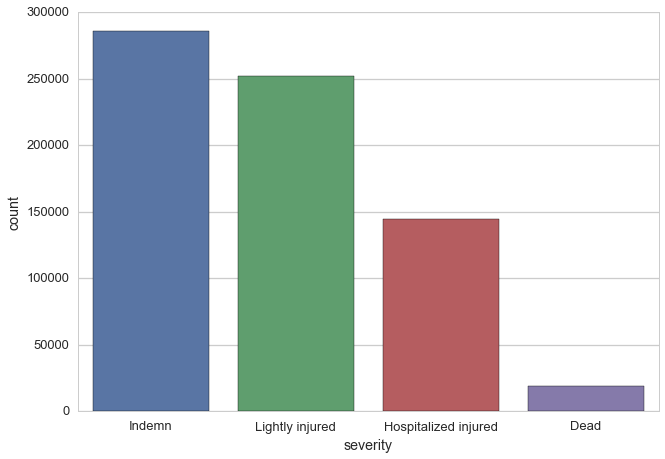

In [34]:
plot_severity(mldata_df)

This could be a big problem for the training of the algorithms since they would predict Indemn and Lightly injured much more often and that would naturally increase the accuracy.
One solution is create a training set that contains a balanced set of the 4 classes.

In [35]:
RatioDead = 100. * mldata_df[mldata_df['severity'] == 2].shape[0] / mldata_df.shape[0]
print('The number of road users who died in their accident represents about {:.1f}% of the total number of recorded users'.format(RatioDead))

The number of road users who died in their accident represents about 2.7% of the total number of recorded users


## Create the training sample
Since we already shuffled the entries in the dataset prior to storing them in the SQL database, we can just use X entries to have a totally random sample for testing. However for the training sample we need to correct for the class imbalance first.

We will use part of the original dataset to create our training sample.

In [36]:
raw_training_df = mldata_df.head(100000)
n_sev2 = raw_training_df[raw_training_df.severity==2].shape[0]
print("We have {} entries with severity 2. We need the same amount for the other classes.".format(n_sev2))

We have 2680 entries with severity 2. We need the same amount for the other classes.


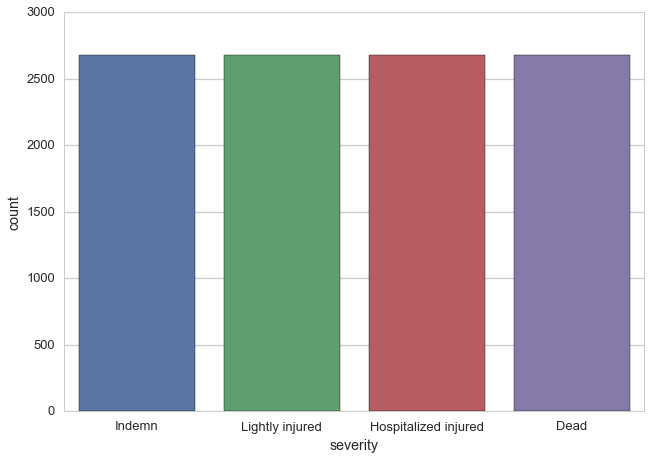

In [37]:
list_severities = []
for sev_id in range(1,5):
    list_severities.append(raw_training_df[raw_training_df.severity==sev_id].head(n_sev2))
training_df = pd.concat(list_severities)
plot_severity(training_df)

Now our training sample is totally balanced.

### Convert categorical variables
In order to process the dataset through machine learning algorithms we must first convert each category into a binary variable. Pretty much all the columns are categories except for the age and the weight differential so we'll remove them from the list of columns that needs to be converted.

In [38]:
all_col = training_df.columns
categ_col = all_col.drop(['severity','age','weight diff'])
training_df = pd.get_dummies(training_df,prefix=categ_col, columns=categ_col)
training_df.head()

,severity,age,weight diff,location in vehicle_0,location in vehicle_1,location in vehicle_2,location in vehicle_3,location in vehicle_4,location in vehicle_5,location in vehicle_6,...,road surface_6,road surface_7,road surface_8,road surface_9,location_0,location_1,location_2,location_3,location_4,location_5
202258,1,41.00,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
630819,1,33.00,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
370905,1,87.00,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
353309,1,32.00,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
675572,1,67.00,-1300,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


### Rescale the continuous variables
Many machine learning algorithms will performed better if all the variables have the sample scale. At the moment the categorical variables take values 0 and 1. The weight differential range on the other hand is few orders of magnitude larger.

In [39]:
training_df[['age','weight diff']].describe().loc[['min','max']]

,age,weight diff
min,0.00,"-199,820.00"
max,99.00,"60,000.00"


In [40]:
max_age = training_df['age'].max()
training_df['age'] = training_df['age'] / max_age

In [41]:
max_weight_diff = training_df['weight diff'].max()
min_weight_diff = training_df['weight diff'].min()
training_df['weight diff'] = (training_df['weight diff'] - min_weight_diff) / (max_weight_diff - min_weight_diff)

In [42]:
training_df[['age','weight diff']].describe().loc[['min','max']]

,age,weight diff
min,0.00,0.00
max,1.00,1.00


## Create the testing sample
We must convert the categorical variables and rescale the continuous variables using the same scaling factors as for the training sample.

In [43]:
testing_df = mldata_df.head(120000).tail(20000)

In [44]:
all_col = testing_df.columns
categ_col = all_col.drop(['severity','age','weight diff'])
testing_df = pd.get_dummies(testing_df,prefix=categ_col, columns=categ_col)
testing_df.head()

,severity,age,weight diff,location in vehicle_0,location in vehicle_1,location in vehicle_2,location in vehicle_3,location in vehicle_4,location in vehicle_5,location in vehicle_6,...,road surface_6,road surface_7,road surface_8,road surface_9,location_0,location_1,location_2,location_3,location_4,location_5
463449,3,17.00,1200,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
388004,1,11.00,-9800,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
694170,1,52.00,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
255086,4,20.00,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
390787,1,65.00,0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [45]:
testing_df['age'] = testing_df['age'] / max_age
testing_df['weight diff'] = (testing_df['weight diff'] - min_weight_diff) / (max_weight_diff - min_weight_diff)
testing_df[['age','weight diff']].describe().loc[['min','max']]

,age,weight diff
min,0.00,-0.00
max,0.99,1.54


The weight differential here is not between 0.0 and 1.0 because it happens to have different minimum and maximum however it is on the sample scale as the training sample.

Both the training and the testing samples are ready to be used in a machine algorithm now.